# **데이터 기반 금융·외환 조기경보모형**
**Ⅰ. 데이터 입수 및 변환**

**Ⅱ. 모형 하이퍼파라미터 튜닝 및 평가**

**Ⅲ. 모형 학습 및 예측**

- [💾이슈노트 다운로드](./BOK_issue_note_2024-11.pdf)
- [💾코드 다운로드](./ews.py)

# Ⅰ. 데이터 입수 및 변환

## 1 데이터 입수

In [3]:
import ews
import pandas as pd


# 메타데이터 로딩
meta = pd.read_excel('ews.xlsx', header=0, index_col='Data ID', sheet_name='meta')
features = {'id': [], 'type': [], 'group': [], 'name': []}
for var, row in meta[meta['Feature'] == 'Y'].iterrows():
    features['id'].append(var)
    features['type'].append(row['Group1'])
    features['group'].append(row['Group2'])
    features['name'].append(row['Data Name'])

# Bidas 데이터  입수
bidas_ids = meta['BIDAS ID'].dropna().values
api_headers = {'user': '2320495', 'node': 'TCAA20200504'}#Fairs 권한 부여이슈로 삭제 Bidas에 배포시 삭제!
bidas = ews.Bidas('API', api_headers=api_headers)

range_from = '1997-07-01'
range_to = '2024-11-06'
table = bidas.get_table(bidas_ids, 'M', range_from, range_to)

# 변수 이름을 별칭으로 변경
aliases = {bidas_id: alias for alias, bidas_id in meta['BIDAS ID'].dropna().items()}
table.rename(columns=aliases, inplace=True)

NECOS-311U004-Q-A500000 is not loaded.
NECOS-311U004-Q-A500000 is not loaded.


KeyError: 'FAIRS-AA004-AA1100S-PZ00000-A-1-6'

In [16]:
bidas_ids

array(['NECOS-200U105-Q-1400', 'NECOS-732U001-M-99',
       'NECOS-311U004-Q-A500000', 'FAIRS-AA004-AA1100S-PZ00000-A-1-6',
       'FAIRS-AA004-AA1100S-CZ00000-A-1-6', 'NECOS-104U015-M-BDAA1',
       'NECOS-104U016-M-BDCA1', 'NECOS-151U001-Q-1000000',
       'NECOS-281U005-Q-205000-2-C290', 'NECOS-281U005-Q-206000-2-C290',
       'NECOS-281U005-Q-208000-2-C290', 'NECOS-281U005-Q-209000-2-C290',
       'NECOS-281U007-Q-304000-L-C4000', 'NECOS-281U007-Q-305000-L-C4000',
       'NECOS-281U007-Q-306000-L-C4000', 'NECOS-281U002-Q-F04TTB-L-S14',
       'NECOS-281U002-Q-F05TTB-L-S14', 'NECOS-281U002-Q-F06ZTB-L-S14',
       'NECOS-281U005-Q-205000-2-C260', 'NECOS-281U005-Q-206000-2-C260',
       'NECOS-281U005-Q-208000-2-C260', 'NECOS-281U005-Q-209000-2-C260',
       'NECOS-281U007-Q-304000-L-C3200', 'NECOS-281U007-Q-305000-L-C3200',
       'NECOS-281U007-Q-306000-L-C3200', 'NECOS-281U002-Q-F04TTB-L-S112',
       'NECOS-281U002-Q-F05TTB-L-S112', 'NECOS-281U002-Q-F06ZTB-L-S112',
       'KBSTAR-

In [12]:
extract_range = lambda x: [x.first_valid_index(), x.last_valid_index()]
table_scope = table.apply(extract_range).set_axis(['Start', 'End']).T
# 시작일이 1997-08 이후인 데이터(단절 시계열 제외)
table_scope[('1997-07' < table_scope.loc[:, 'Start']) & (table_scope.loc[:, 'Start'] < '2002-10')]

,Start,End
gdp,2000-01,2024-04
ms91,2000-10,2024-11
cp91,1998-06,2024-11
kb10y,2000-12,2024-11
ms1y,2000-10,2024-11
cbaa3y,2000-10,2024-11
krxbank,2001-01,2024-11


In [13]:
# 종료일이 2024-03 이전인 데이터(단절 시계열 제외)
table_scope[('2013-10' < table_scope.loc[:, 'End']) & (table_scope.loc[:, 'End'] < '2024-04')]

,Start,End
kosbank,1997-07,2022-06
gdp_growth,1997-07,2024-01


## 2 데이터 변환

In [14]:
# CFPI, 조기경보모형 관련 변수 생성
table = ews.preprocess(table)
table_scope = table[features['id']].apply(extract_range).set_axis(['Start', 'End']).T
pd.concat([meta[['Data Name', 'Freq', 'Delay']], table_scope], axis=1, join='inner')

,Data Name,Freq,Delay,Start,End
res_sdebt_neg,단기외채 비율,Q,3,1997-07,2024-07
bank_lev_diff,은행 레버리지,M,1,1998-07,2024-10
bank_ldr_diff,은행 예대율,M,3,1998-07,2024-09
hc_gdp_diff,가계신용/GDP,Q,3,2002-02,2024-04
cc_gdp_diff,기업신용/GDP,Q,3,2002-02,2024-04
kb_hp_pchg,주택가격,M,1,1997-10,2024-11
cd_sp_diff,CD 스프레드,D,0,2001-10,2024-11
cp_sp_diff,CP 스프레드,D,0,1999-06,2024-11
sr_sp_diff,국가신용 스프레드,D,0,2001-12,2024-11
tp_sp_neg_diff,기간 프리미엄 스프레드,D,0,2001-10,2024-11


In [15]:
# 공표시차 적용
for id, lag in meta[(meta['Delay'] > 0) & (meta['Feature'] == 'Y')]['Delay'].items():
    table[id] = table[id].shift(lag)
# 현재시점의 빈값은 가장 최근의 값으로, 시작시점의 빈값은 중위값으로 설정
table = table[range_from:range_to].ffill()
table = table.fillna(table.median())

CFSI = 은행부문압력지수 + 채권·주식부문압력지수 + 외환부문압력지수
- 은행부문압력지수 = KRX 은행지수 변동성 + CD스프레드
- 채권·주식부문압력지수 = KOSPI 지수 변동성 - KOSPI 지수 수익률 - 기간프리미엄 - 회사채 스프레드
- 외환부문압력지수 = USD/KRW 환율 변동성

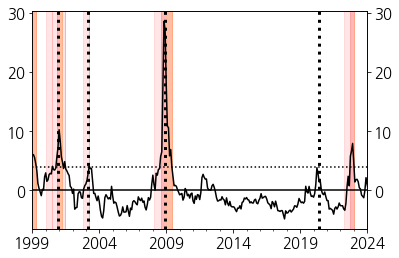

In [7]:
CFPI = ['bank_gv', 'cd_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp', 'er_gv']
cfpi = table[CFPI].transform(ews.Transform.scale).sum(axis=1)

threshold = 1
horizon = 6
crises = ews.get_crises(cfpi, threshold, horizon, group_bgn_ext=3, group_end_ext=3)

gdp_growth = table['gdp_growth'].resample('Q').mean()
ews.plot_cfpi(cfpi, gdp_growth, threshold, horizon)

# Ⅱ. 모형 하이퍼파라미터 튜닝 및 평가

## 1 하이퍼파라미터 튜닝

In [7]:
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)


# 인공신경망 모델 구성
def build_NN(units, features, dropout_prob=0.5):
    model = Sequential()
    model.add(Dense(units=units, input_shape=(features,)))
    model.add(Dropout(dropout_prob))
    model.add(Dense(units=units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(units=units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# 평가 대상 모델 정의
models = {
    'SE': ews.SignalExtraction(),
    'LR': LogisticRegression(max_iter=1000),
    'Lasso': LogisticRegression(solver='liblinear', max_iter=1000, penalty='l1'),
    'Ridge': LogisticRegression(solver='saga', max_iter=1000, penalty='l2'),
    'ElasticNet': LogisticRegression(solver='saga', max_iter=1000, penalty='elasticnet', l1_ratio=0.5),
    'SVM': SVC(C=1.0, kernel='rbf', gamma='scale', probability=True),
    'NN': KerasClassifier(model=build_NN, units=10, features=len(features['id']), verbose=0),
    'RF': RandomForestClassifier(criterion='entropy'),
    'XGB': XGBClassifier(eval_metric='logloss'),
    'ET': ExtraTreesClassifier(),
}

# 모델별 하이퍼파라미터 탐색 범위 정의
model_param_grids = {
    'SE': {'significance': [0.7, 0.75, 0.8, 0.85, 0.9]},
    'LR': {},
    'Lasso': {'C': [1, 5, 10]},
    'Ridge': {'C': [0.1, 1, 10, 20]},
    'ElasticNet': {
        'C': [0.1, 1, 5, 10],
        'l1_ratio': [0.1, 0.5, 0.9]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': [0.01, 0.1, 1],
        'kernel': ['rbf', 'linear']
    },
    'NN': {
        'units': [5, 10, 30, 50],
        'batch_size': [30],
    },
    'RF': {
        'n_estimators': [1000],
        'max_features': [3, 5, 7, 10, 15],
        'max_depth': [5, 7, 10, 12, 15, 17, 20]
    },
    'XGB': {
        'n_estimators': [1000],
        'max_depth': [3, 5],
        'gamma': [0.03, 0.1],
        'colsample_bytree': [0.4],
        'min_child_weight': [1.5, 3],
        'learning_rate': [0.1],
        'reg_alpha': [0.75],
        'reg_lambda' [0.45],
        'subsample': [0.95],
        'objective': ['binary:logistic']
    },
    'ET': {
        'n_estimators': [1000],
        'max_features': [3, 5, 7, 10, 15],
        'max_depth': [15, 20, 30, 40]
    },
}

# 하이퍼파라미터 튜닝 실행
best_params, preds = ews.run_cv(models, model_param_grids, table[features['id']], crises)

  0%|          | 0/10 [00:00<?, ?it/s]

SE 0 - Best Score: 0.871562, Best Params: {'significance': 0.75}
SE 1 - Best Score: 0.803315, Best Params: {'significance': 0.9}
SE 2 - Best Score: 0.861307, Best Params: {'significance': 0.9}
SE 3 - Best Score: 0.881482, Best Params: {'significance': 0.7}
SE 4 - Best Score: 0.829378, Best Params: {'significance': 0.7}
LR 0 - Best Score: 0.492760, Best Params: {}
LR 1 - Best Score: 0.839447, Best Params: {}
LR 2 - Best Score: 0.870978, Best Params: {}
LR 3 - Best Score: 0.816777, Best Params: {}
LR 4 - Best Score: 0.776199, Best Params: {}
Lasso 0 - Best Score: 0.514424, Best Params: {'C': 1}
Lasso 1 - Best Score: 0.833697, Best Params: {'C': 1}
Lasso 2 - Best Score: 0.887146, Best Params: {'C': 1}
Lasso 3 - Best Score: 0.794023, Best Params: {'C': 1}
Lasso 4 - Best Score: 0.754210, Best Params: {'C': 1}
Ridge 0 - Best Score: 0.681802, Best Params: {'C': 0.1}
Ridge 1 - Best Score: 0.865121, Best Params: {'C': 0.1}
Ridge 2 - Best Score: 0.903397, Best Params: {'C': 0.1}
Ridge 3 - Best S

  0%|          | 0/10 [00:00<?, ?it/s]

            tp   tn  fp  fn       acc       tpr    fpr       nsr        f1  \
SE           4  250   0  71  0.781538  0.053333  0.000       NaN  0.101266   
LR          47  227  23  28  0.843077  0.626667  0.092  0.146809  0.648276   
Lasso       46  227  23  29  0.840000  0.613333  0.092  0.150000  0.638889   
Ridge       48  230  20  27  0.855385  0.640000  0.080  0.125000  0.671329   
ElasticNet  50  227  23  25  0.852308  0.666667  0.092  0.138000  0.675676   
SVM          0  250   0  75  0.769231  0.000000  0.000       NaN  0.000000   
NN          46  202  48  29  0.763077  0.613333  0.192  0.313043  0.544379   
RF          21  249   1  54  0.830769  0.280000  0.004  0.014286  0.432990   
XGB         30  245   5  45  0.846154  0.400000  0.020  0.050000  0.545455   
ET          15  249   1  60  0.812308  0.200000  0.004  0.020000  0.329670   

                 auc  
SE          0.879760  
LR          0.851733  
Lasso       0.840907  
Ridge       0.886027  
ElasticNet  0.872000  
SVM

Mean: 0.10759692307692306
Median: 0.021
70th Percentile: 0.105
90th Percentile: 0.3690000000000001


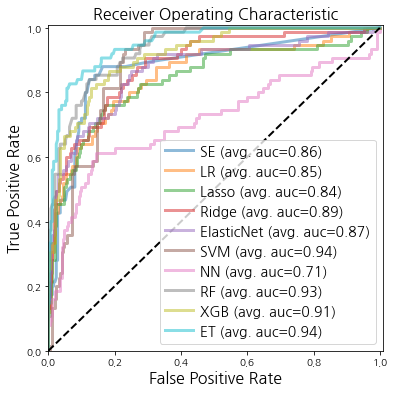

In [8]:
# (기존) 경보 지수 중위값 : 0.03, 70분위값 : 0.14, 90분위값 : 0.31
mean_value = preds['ET'].mean()
median_value = preds['ET'].median()
perc70 = preds['ET'].quantile(0.7)
perc90 = preds['ET'].quantile(0.9)
print('Mean:', mean_value)
print('Median:', median_value)
print('70th Percentile:', perc70)
print('90th Percentile:', perc90)
# ROC 곡선 및 AUC값 확인
ews.plot_roc_curve(preds)

## 2 과거 위기기간별 모형성능 검증

In [8]:
from sklearn.ensemble import ExtraTreesClassifier


model_params =  {
    'SE': {'significance': 0.9},
    'ET': {'max_depth': 30, 'max_features': 3, 'n_estimators': 1000}
}
et_model = ExtraTreesClassifier(**model_params['ET'])
se_model = ews.SignalExtraction(**model_params['SE'])
et = ews.EarlyWarningModel(et_model)
se = ews.EarlyWarningModel(se_model)


# 반복 실행을 위한 함수 - 전역변수 사용
def train_and_predict(train_from, train_to, predict_from, predict_to):
    # 예측구간 데이터
    predict_idx = (predict_from <= table.index) & (table.index <= predict_to)
    # 학습구간 데이터 (디레버리징 기간 및 예측구간 제외)
    train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises.post_term == 0)
    train_idx &= ~predict_idx
    X_train = table[features['id']][train_idx]
    y_train = crises.ext_term[train_idx]
    X = table[features['id']][predict_idx]
    # ET는 전망+요인분해
    et.train(X_train, y_train)
    et_results, et_impacts = et.predict(X, True)
    # SE는 전망만
    se.train(X_train, y_train)
    se_results, _ = se.predict(X)
    # 예측결과 차트
    results = {'ET': et_results, 'SE': se_results}
    ews.plot_predicted(results, crises, perc70, perc90)
    # 변수별 기여도 차트
    ews.plot_decomposed(et_impacts, features['id'], features['group'])

### 글로벌 금융위기 (2007.1 ~ 2008.12)

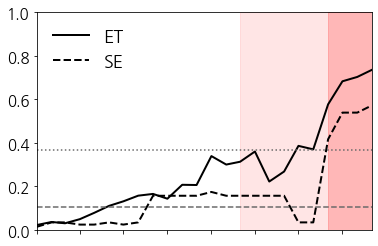

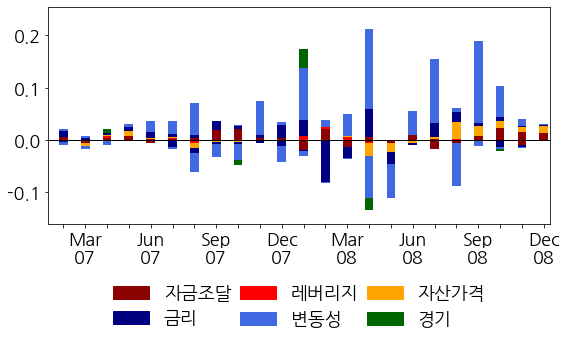

In [10]:
train_from = '1997-07'
train_to = '2006-12'
predict_from = '2007-01'
predict_to = '2008-12'

train_and_predict(train_from, train_to, predict_from, predict_to)

### 코로나 19 (2018.10 ~ 2020.5)

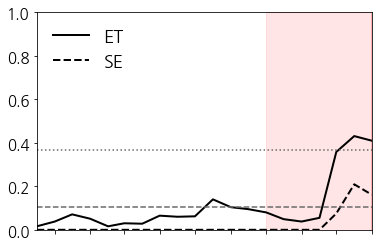

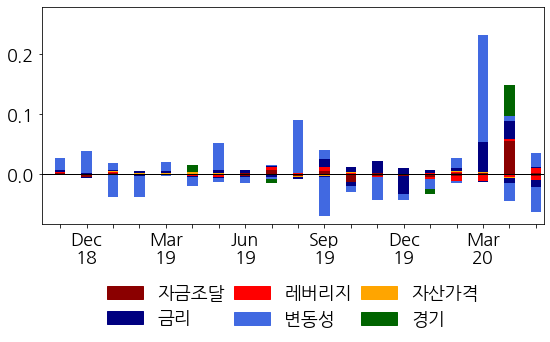

In [11]:
train_from = '1997-07'
train_to = '2018-09'
predict_from = '2018-10'
predict_to = '2020-05'

train_and_predict(train_from, train_to, predict_from, predict_to)

### 레고랜드 (2021.7 ~ 2023.1)

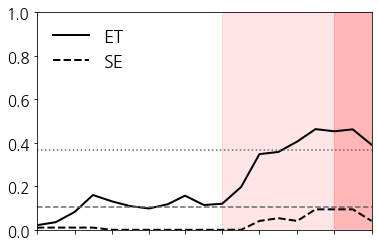

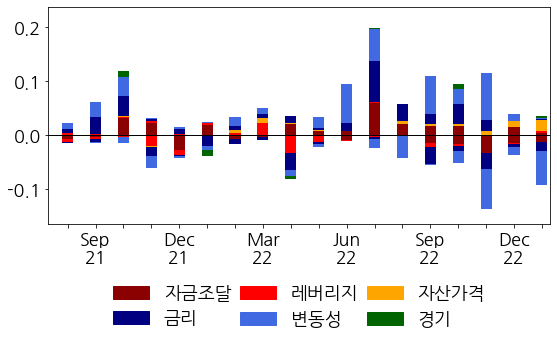

In [12]:
train_from = '1997-07'
train_to = '2021-06'
predict_from = '2021-07'
predict_to = '2023-01'

train_and_predict(train_from, train_to, predict_from, predict_to)

# Ⅲ. 모형 학습 및 예측

## 1 학습

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier


# 모델 초기화
model_param = {'max_depth': 30, 'max_features': 3, 'n_estimators': 1000}
model = ExtraTreesClassifier()
model.set_params(**model_param)
et = ews.EarlyWarningModel(model)

# 학습 및 결과 저장
train_from = '1997-07'
train_to = '2024-01'
model_id = '20240430'

train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises.post_term == 0)
X_train = table[features['id']][train_idx]
y_train = crises.ext_term[train_idx]

et.train(X_train, y_train)
et.save(model_id)

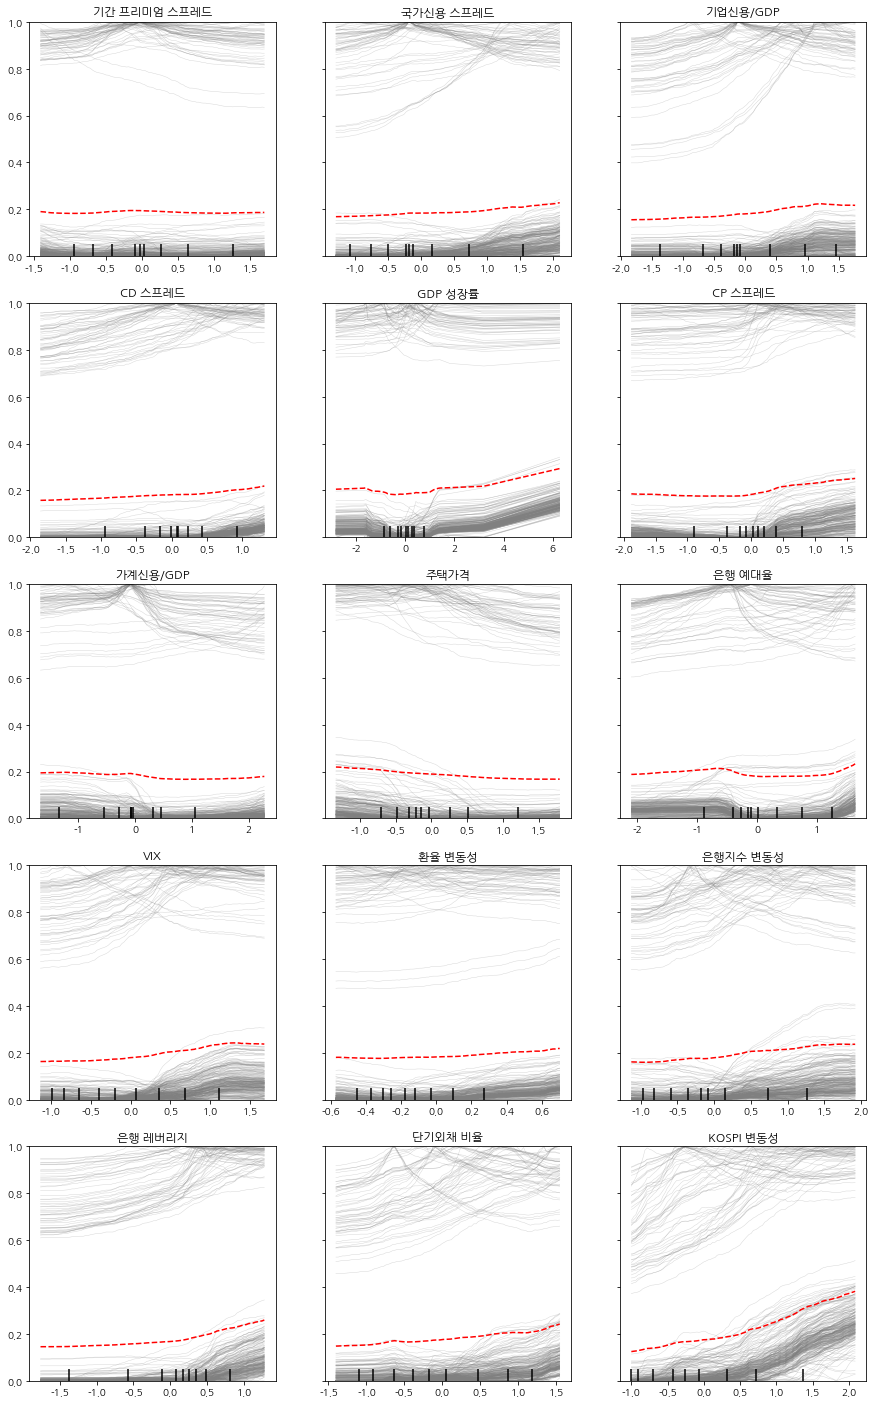

In [14]:
# pdp one-way
ews.plot_pdp_oneway(et.model, et.scale(X_train), features['name'])

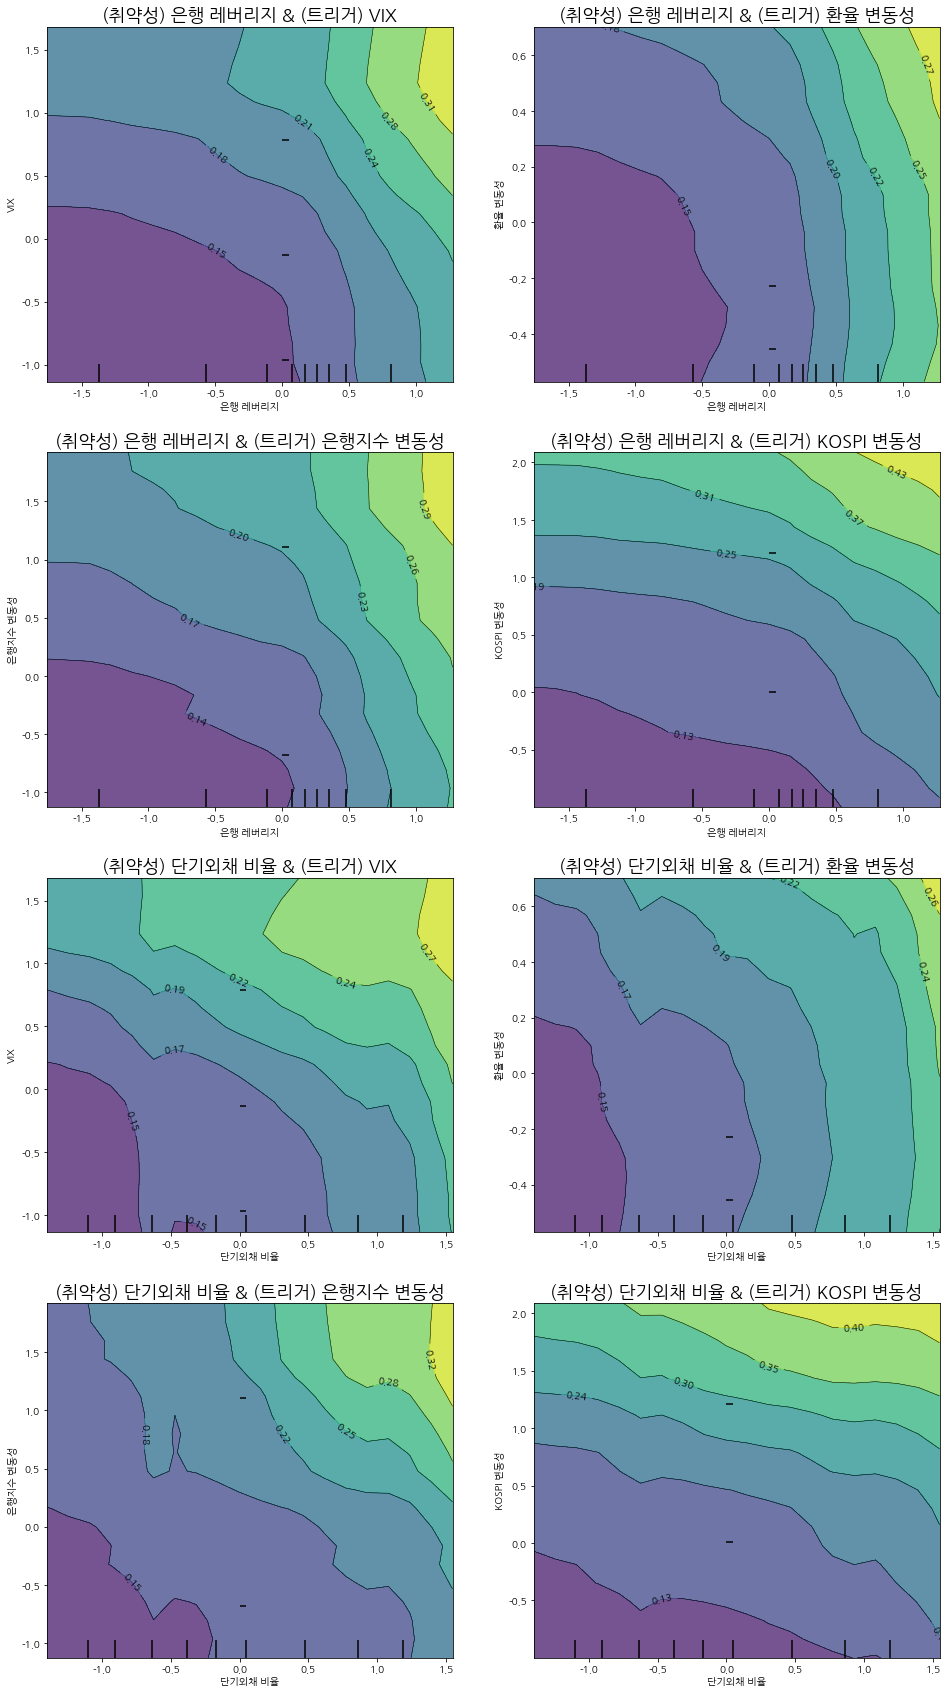

In [15]:
# pdp two-way
ews.plot_pdp_twoway(et.model, et.scale(X_train), features['name'], features['type'])

## 2 전망

In [8]:
# 모델 로딩 및 전망
model_id = '20240430'
#model_id = '20240631'
predict_from = '2023-10'
predict_to = '2024-11'

et = ews.EarlyWarningModel()
et.load(model_id)

predict_idx = (predict_from <= table.index) & (table.index <= predict_to)
X = table[features['id']][predict_idx]

et_results, et_impacts = et.predict(X, True)
se_results, _ = et.predict(X)
# (기존) 예측값
# (5.9)
# 24.3월말 : 0.03
# 24.4월말 : 0.04
# 24.5.9일 : 0.043

# (6.10) - 국민계정 개편으로 결과가 달라졌다고 통보
# 24.3월말 : 0.02 (당초 0.03)
# 24.4월말 : 0.04 (당초 0.04)
# 24.5월말 : 0.05 (당초 0.04, 5.9일 기준)
# 24.6.10일 : 0.054

# (7.1)
# 24.5월말 : 0.05
# 24.6월말 : 0.05
# 24.7.1일 : 0.08
print(et_results[-3:])

             pred
period           
2024-09-01  0.031
2024-10-01  0.062
2024-11-01  0.066


In [9]:
et_impacts

impact
period     variable             
2023-11-01 res_sdebt_neg     0.0
           bank_lev_diff     0.0
           bank_ldr_diff     0.0
           hc_gdp_diff       0.0
           cc_gdp_diff       0.0
...                          ...
2024-11-01 stock_cmax      0.003
           bank_mv         0.001
           vix             0.003
           er_mv          -0.002
           gdp_growth_neg    0.0

[195 rows x 1 columns]

In [10]:
X

,res_sdebt_neg,bank_lev_diff,bank_ldr_diff,hc_gdp_diff,cc_gdp_diff,kb_hp_pchg,cd_sp_diff,cp_sp_diff,sr_sp_diff,tp_sp_neg_diff,stock_cmax,bank_mv,vix,er_mv,gdp_growth_neg
period,,,,,,,,,,,,,,,
2023-10,-2887.289313,-1.176706,3.454422,-0.033835,0.029739,-0.000611,-0.469105,-0.346842,-0.823528,0.348526,-0.805552,0.027404,18.887727,0.016784,-0.6
2023-11,-2863.312885,-0.989448,3.183901,-0.031416,0.026078,0.000227,-0.402000,-1.354545,-0.649373,-0.001455,-0.833050,0.027071,14.019091,0.021582,-0.6
2023-12,-2834.677941,-0.690530,3.956883,-0.030156,0.021279,0.000414,-0.250486,-1.556182,-0.515984,0.046518,-0.899386,0.028100,12.718500,0.018986,-0.6
2024-01,-2934.600388,-0.381154,5.098048,-0.030676,0.016752,-0.000059,-0.017805,-0.800795,-0.549737,-0.037055,-0.929503,0.022973,13.388636,0.019020,-0.6
2024-02,-2964.497511,0.084022,4.133803,-0.032126,0.011299,-0.000656,0.196176,-0.113374,-0.485317,-0.038568,-0.983665,0.068596,13.980476,0.017534,-0.6
2024-03,-2986.304143,-0.043027,3.103047,-0.034493,0.004930,-0.000918,0.001241,0.187477,-0.598079,0.046850,-1.000000,0.069270,13.787500,0.016793,-0.6
2024-04,-2948.116805,0.203503,2.043869,-0.029264,-0.002080,-0.001002,-0.140445,0.164310,-0.832082,-0.046895,-0.999459,0.081301,16.137727,0.019513,-1.3
2024-05,-2947.973050,0.451051,1.331804,-0.024289,-0.009349,-0.000724,-0.103700,0.250700,-0.779836,-0.127050,-1.000000,0.080766,13.058696,0.012316,-1.3
2024-06,-2972.882329,0.254839,0.133236,-0.019563,-0.016870,-0.000736,-0.086779,0.227749,-0.838535,0.099383,-1.000000,0.084676,12.667000,0.011034,-1.3


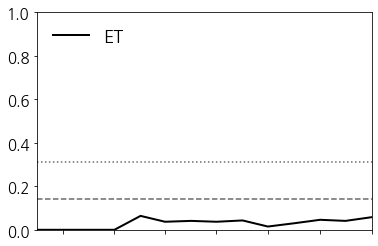

In [13]:
# 예측결과 차트
perc70 = 0.14
perc90 = 0.31
results = {'ET': et_results}
ews.plot_predicted(results, perc70=perc70, perc90=perc90)

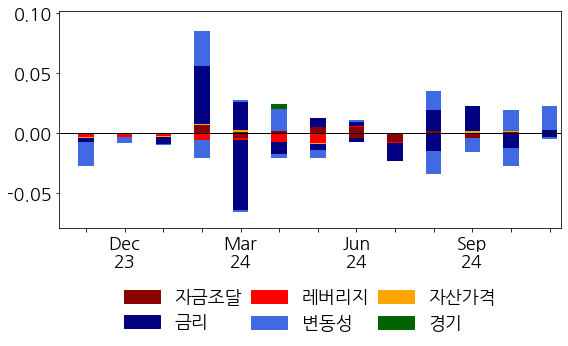

In [14]:
# 변수별 기여도 차트
ews.plot_decomposed(et_impacts, features['id'], features['group'])